In [16]:
import torch
from torchvision import models
from torchvision import transforms
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import math

label_map = {"Airplane": 0, "Bicycle": 1, "Butterfly": 2, "Car": 3, "Flower": 4, "House": 5, "Ladybug": 6, "Train": 7, "Tree": 8, "Whale": 9}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


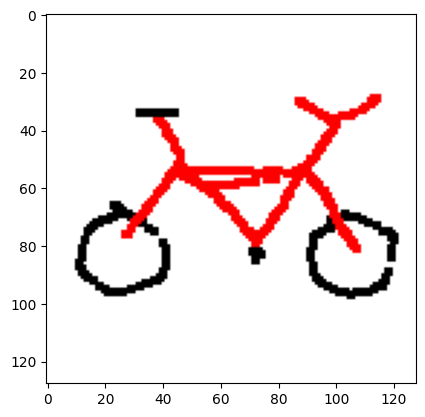

In [30]:
# Load in testing image
img = Image.open("../../data/Bicycle/Bicycle_1708470994525.png").convert("RGB")
base_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
                    ])
img = base_transform(img)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [31]:
model = models.resnet18(weights="DEFAULT")
# Add on custom classifier
classifier = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(512, 256)),
    ('relu', torch.nn.ReLU()),
    ('fc2', torch.nn.Linear(256, 10)),
    ('output', torch.nn.Softmax(dim=1))
]))

model.fc = classifier
model = model.to(device)
model.load_state_dict(torch.load("../../saved_models/TL_resnet18.pth"))
model.eval()
print("Model loaded successfully")

Model loaded successfully


In [32]:
# Make prediction
with torch.no_grad():
    img = img.unsqueeze(0).to(device)
    output = model(img)
    _, pred = torch.max(output, 1)
    print(f"Predicted class: {list(label_map.keys())[list(label_map.values()).index(pred.item())]}")
    print(f"Predicted class index: {pred.item()}")
    print(f"Prediction confidence: {torch.max(output).item()}")

Predicted class: Bicycle
Predicted class index: 1
Prediction confidence: 0.9999994039535522


In [9]:
def get_feature_maps(model, img, layer_name):
    feature_maps = []
    def hook_fn(module, input, output):
        feature_maps.append(output)
    for name, layer in model.named_modules():
        if name == layer_name:
            layer.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img)
    return feature_maps

In [10]:
# Print all layer names
for name, layer in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [21]:
# Get intermediate layer output
feature_maps_conv1 = get_feature_maps(model, img, "conv1")
print(len(feature_maps_conv1))
print(feature_maps_conv1[0].shape)
feature_maps_layer1 = get_feature_maps(model, img, "layer1")
feature_maps_layer2 = get_feature_maps(model, img, "layer2")
feature_maps_layer3 = get_feature_maps(model, img, "layer3")
feature_maps_layer4 = get_feature_maps(model, img, "layer4")

1
torch.Size([1, 64, 64, 64])


In [17]:
def show_k_feature_map_channels(feature_map, k=10):
    # Calculate rows and columns for subplots
    num_columns = min(k, 5)  # Max 5 columns or less if k is smaller
    num_rows = math.ceil(k / num_columns)
    # Adjust figsize based on rows and columns for better visibility
    fig_width = num_columns * 4  # Each column gets 4 inches of width
    fig_height = num_rows * 3.2  # Each row gets 3.2 inches of height
    fig, ax = plt.subplots(num_rows, num_columns, figsize=(fig_width, fig_height))
    # Flatten the axes array for easier iteration if there are multiple axes
    ax_flat = ax.flat if k > 1 else [ax]
    # Display the first k feature map channels
    for i in range(k):
        # Calculate the index for the current subplot
        row_idx = i // num_columns
        col_idx = i % num_columns
        # Handle case where k=1 and ax is not an array
        current_ax = ax_flat[i] if k > 1 else ax
        # Plot the feature map
        current_ax.imshow(feature_map[0, i].cpu().numpy(), cmap="viridis")
        current_ax.axis('off')  # Hide axes ticks
    for j in range(i + 1, num_rows * num_columns):
        fig.delaxes(ax_flat[j])
    plt.tight_layout()
    plt.show()


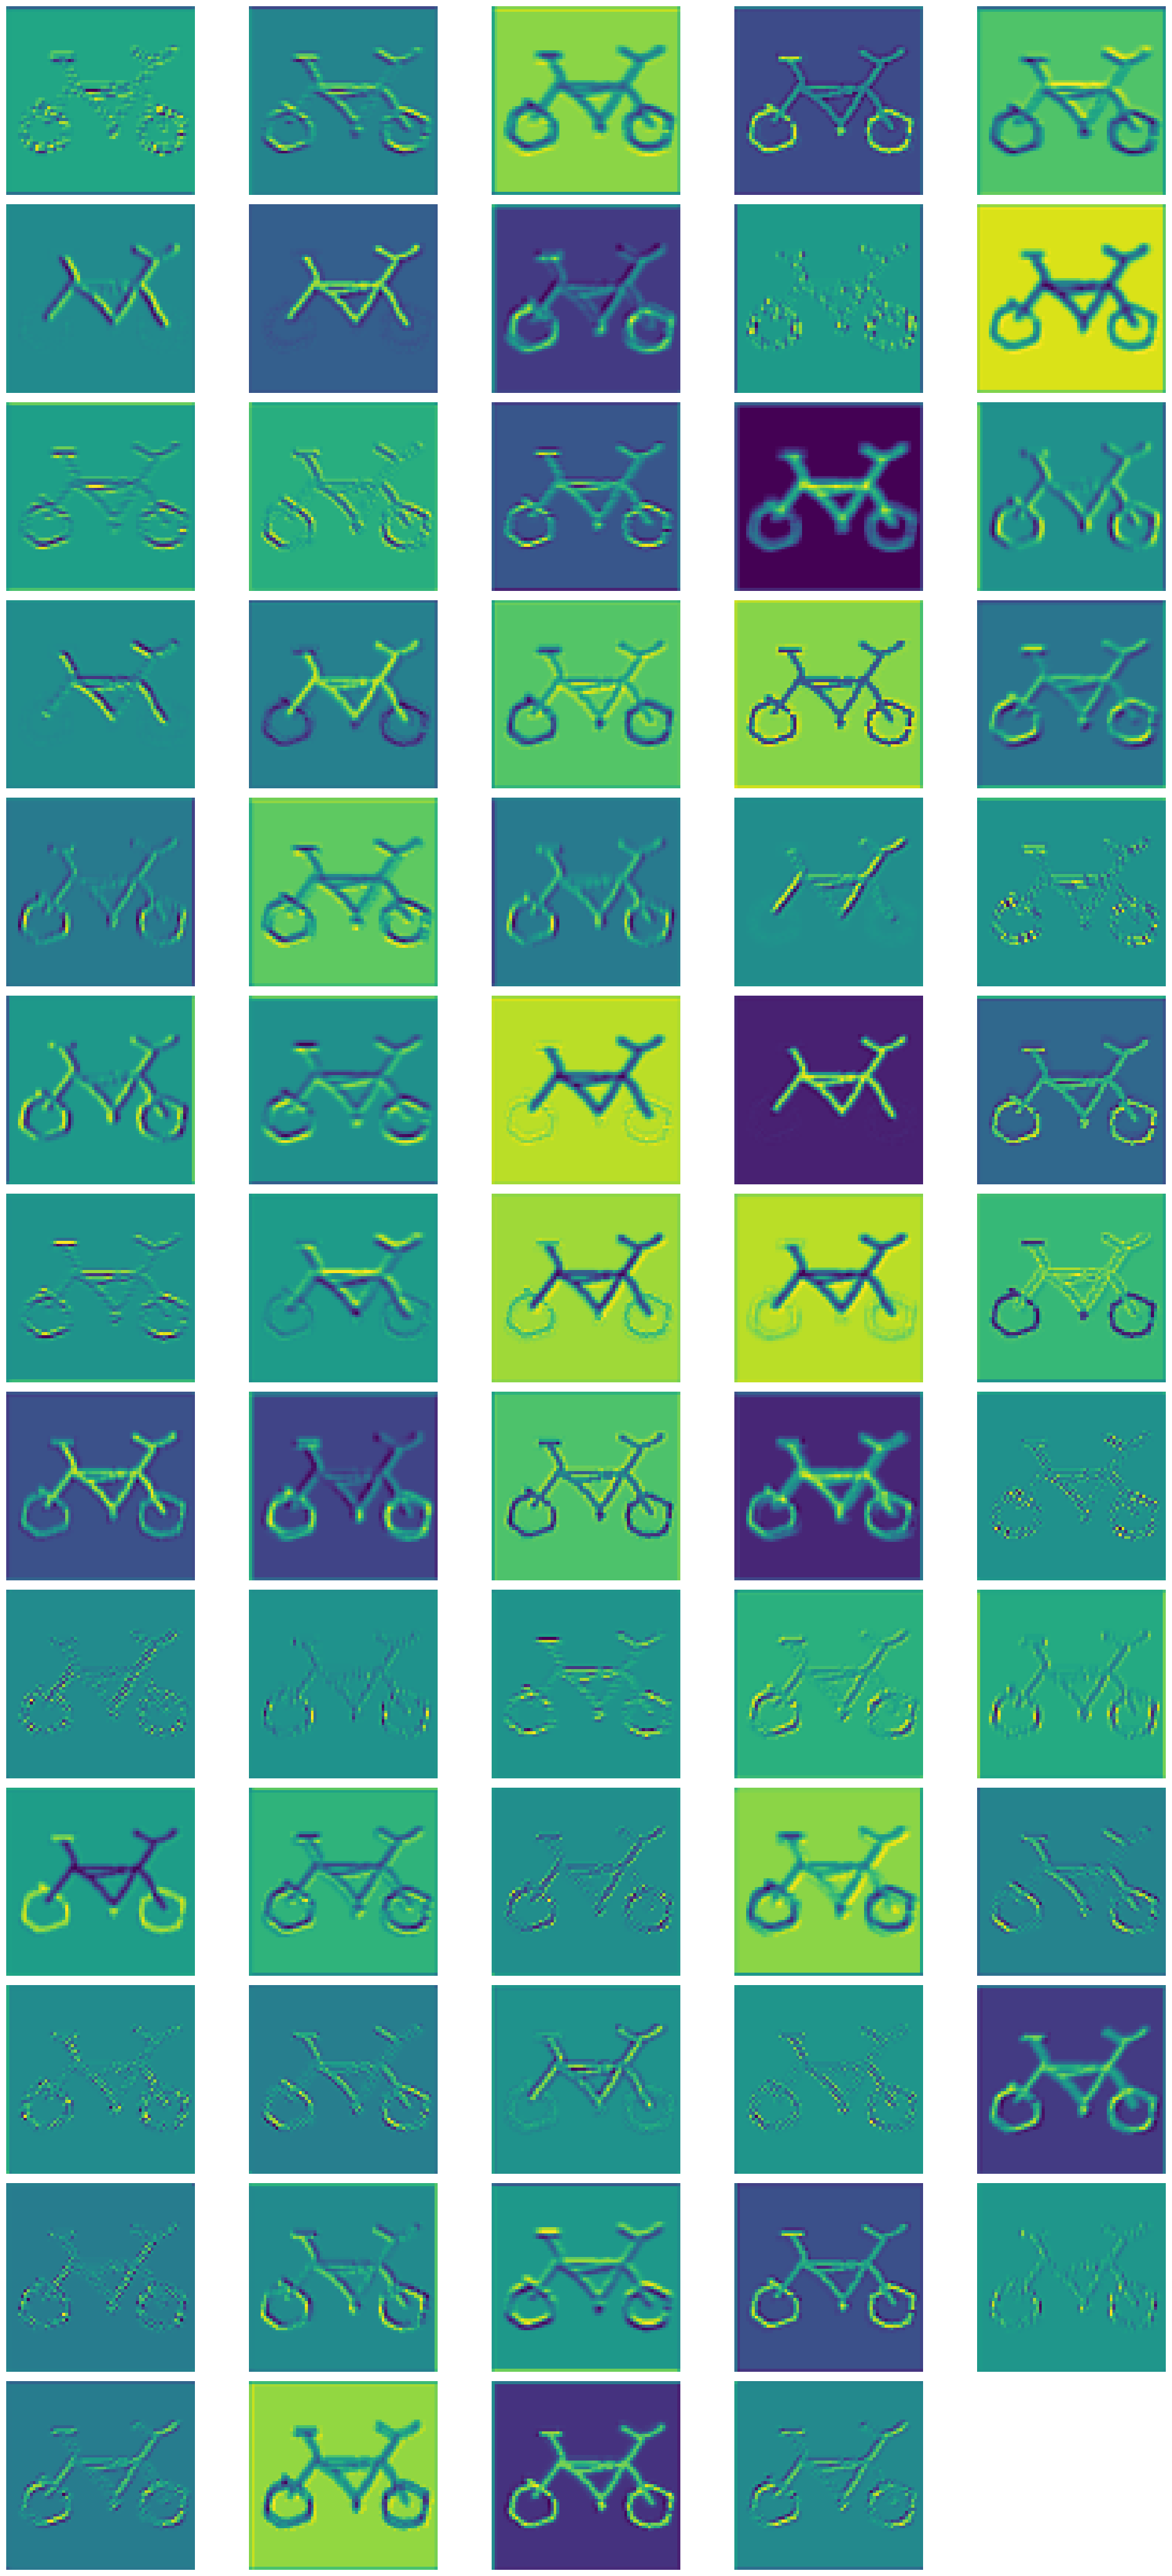

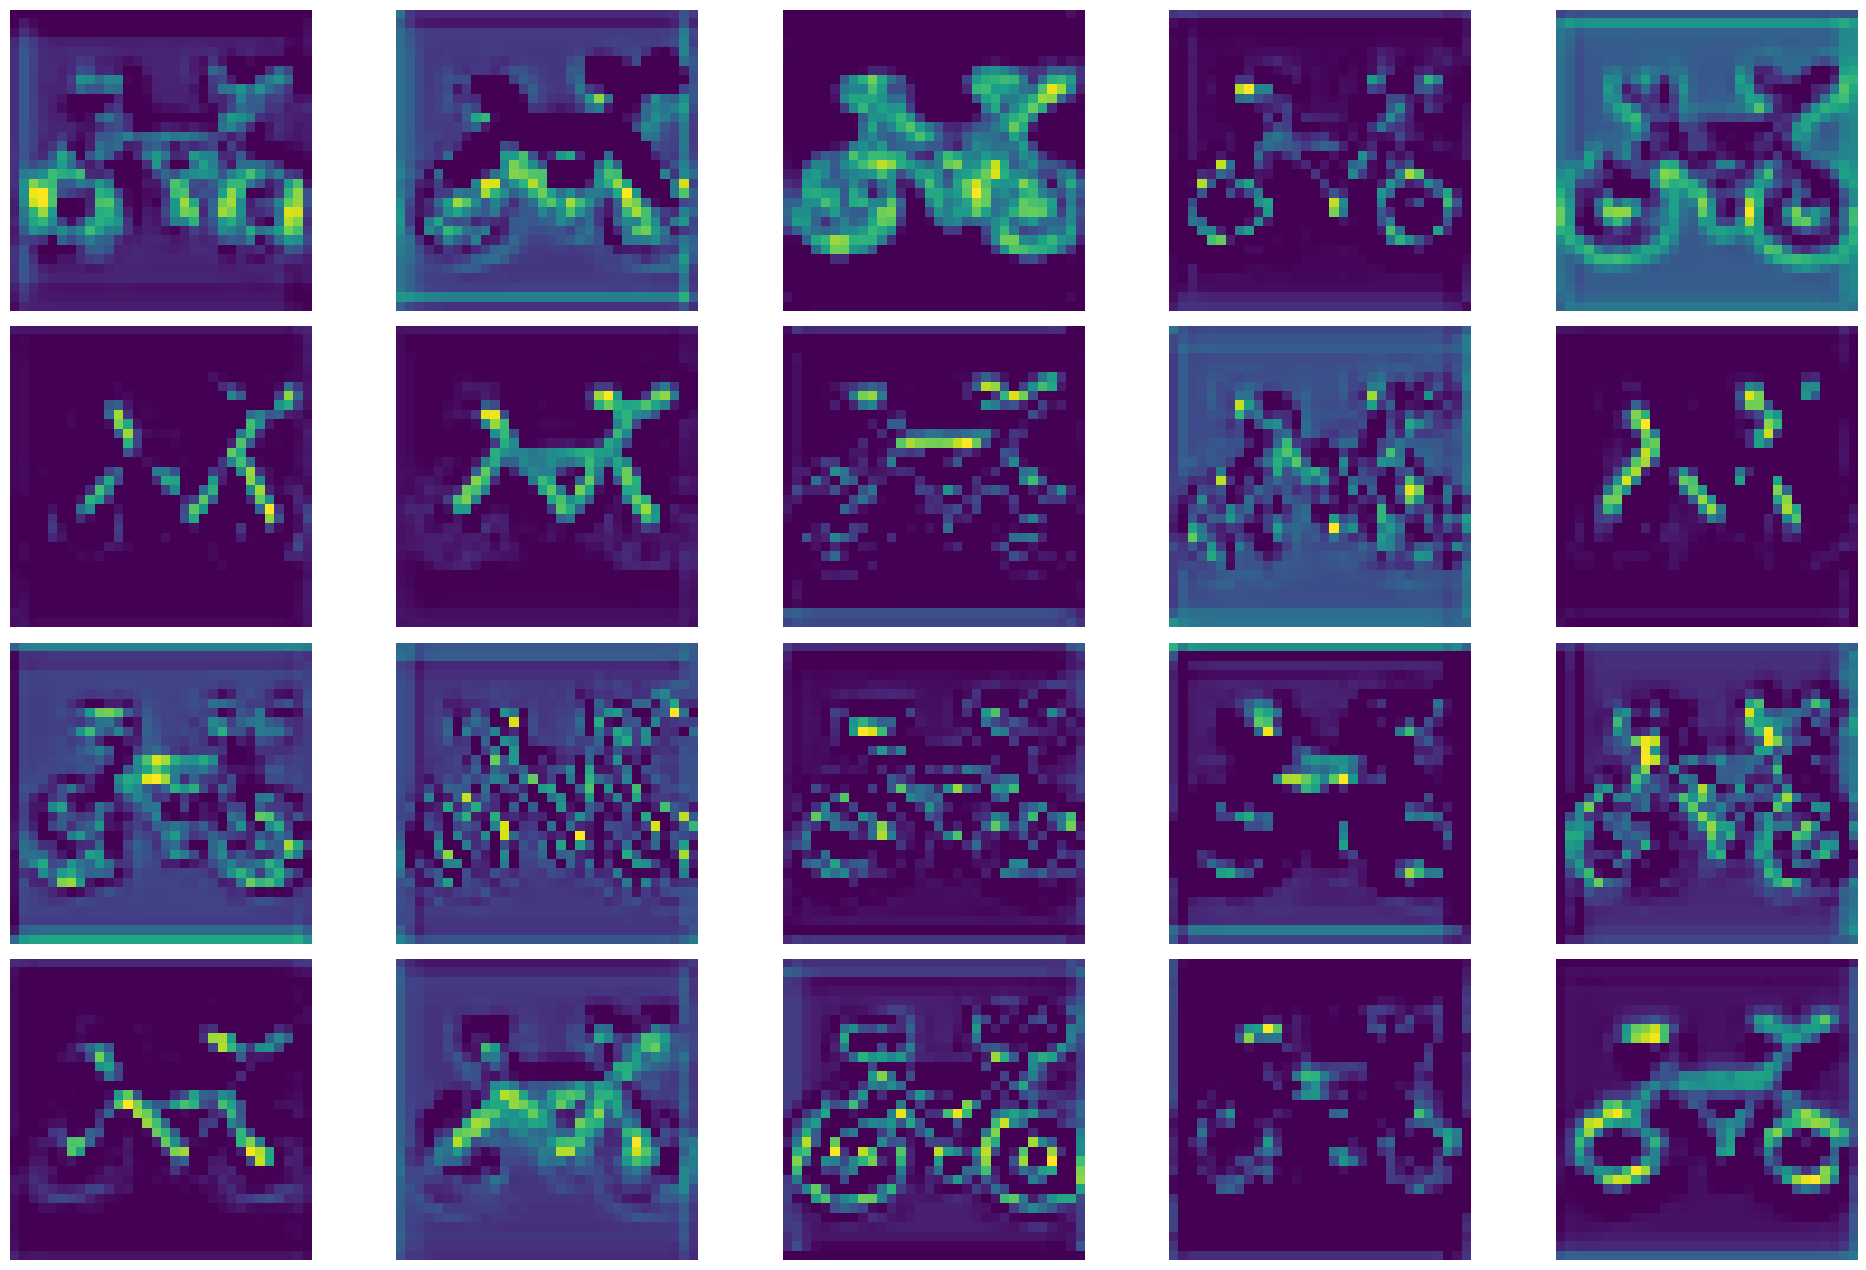

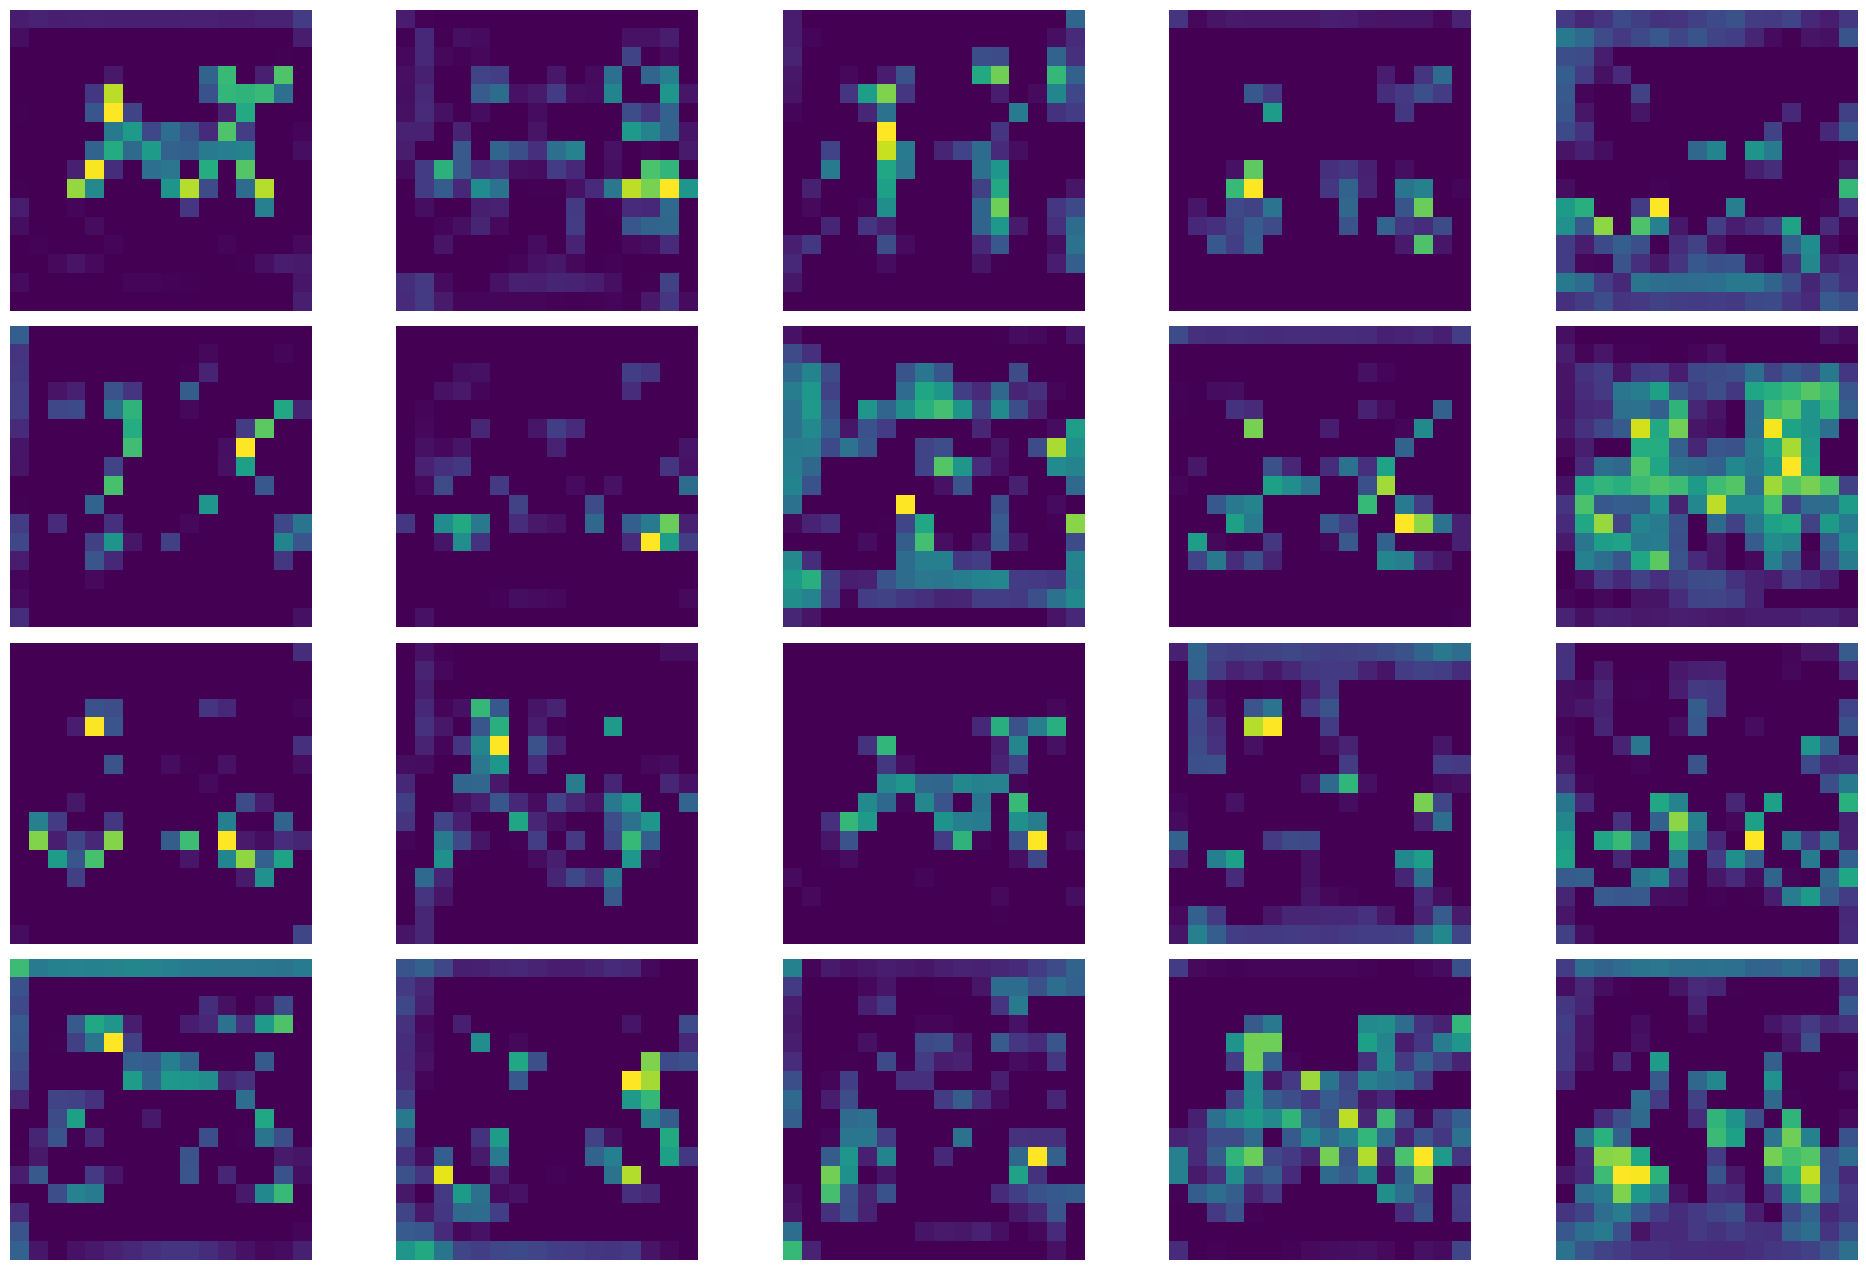

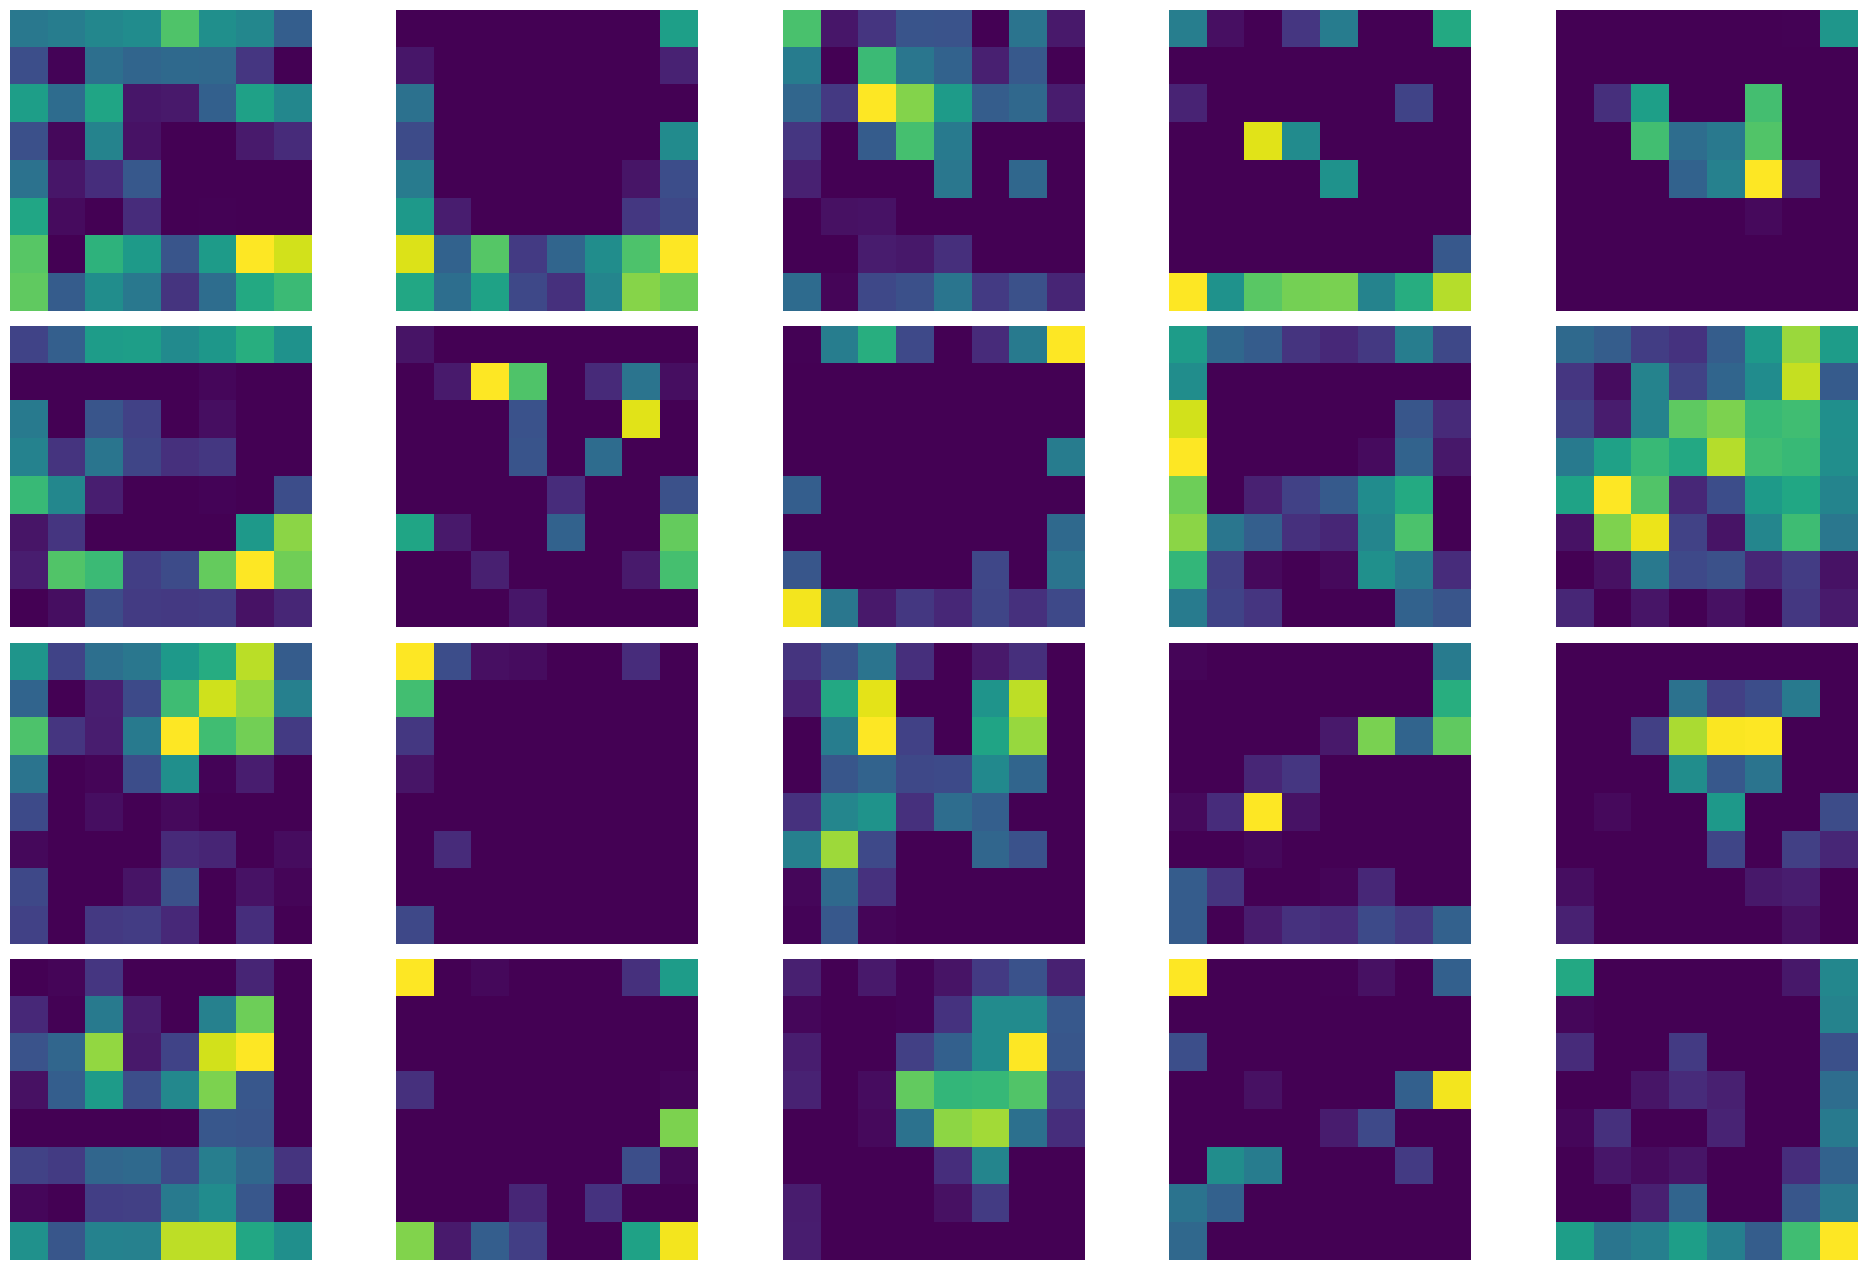

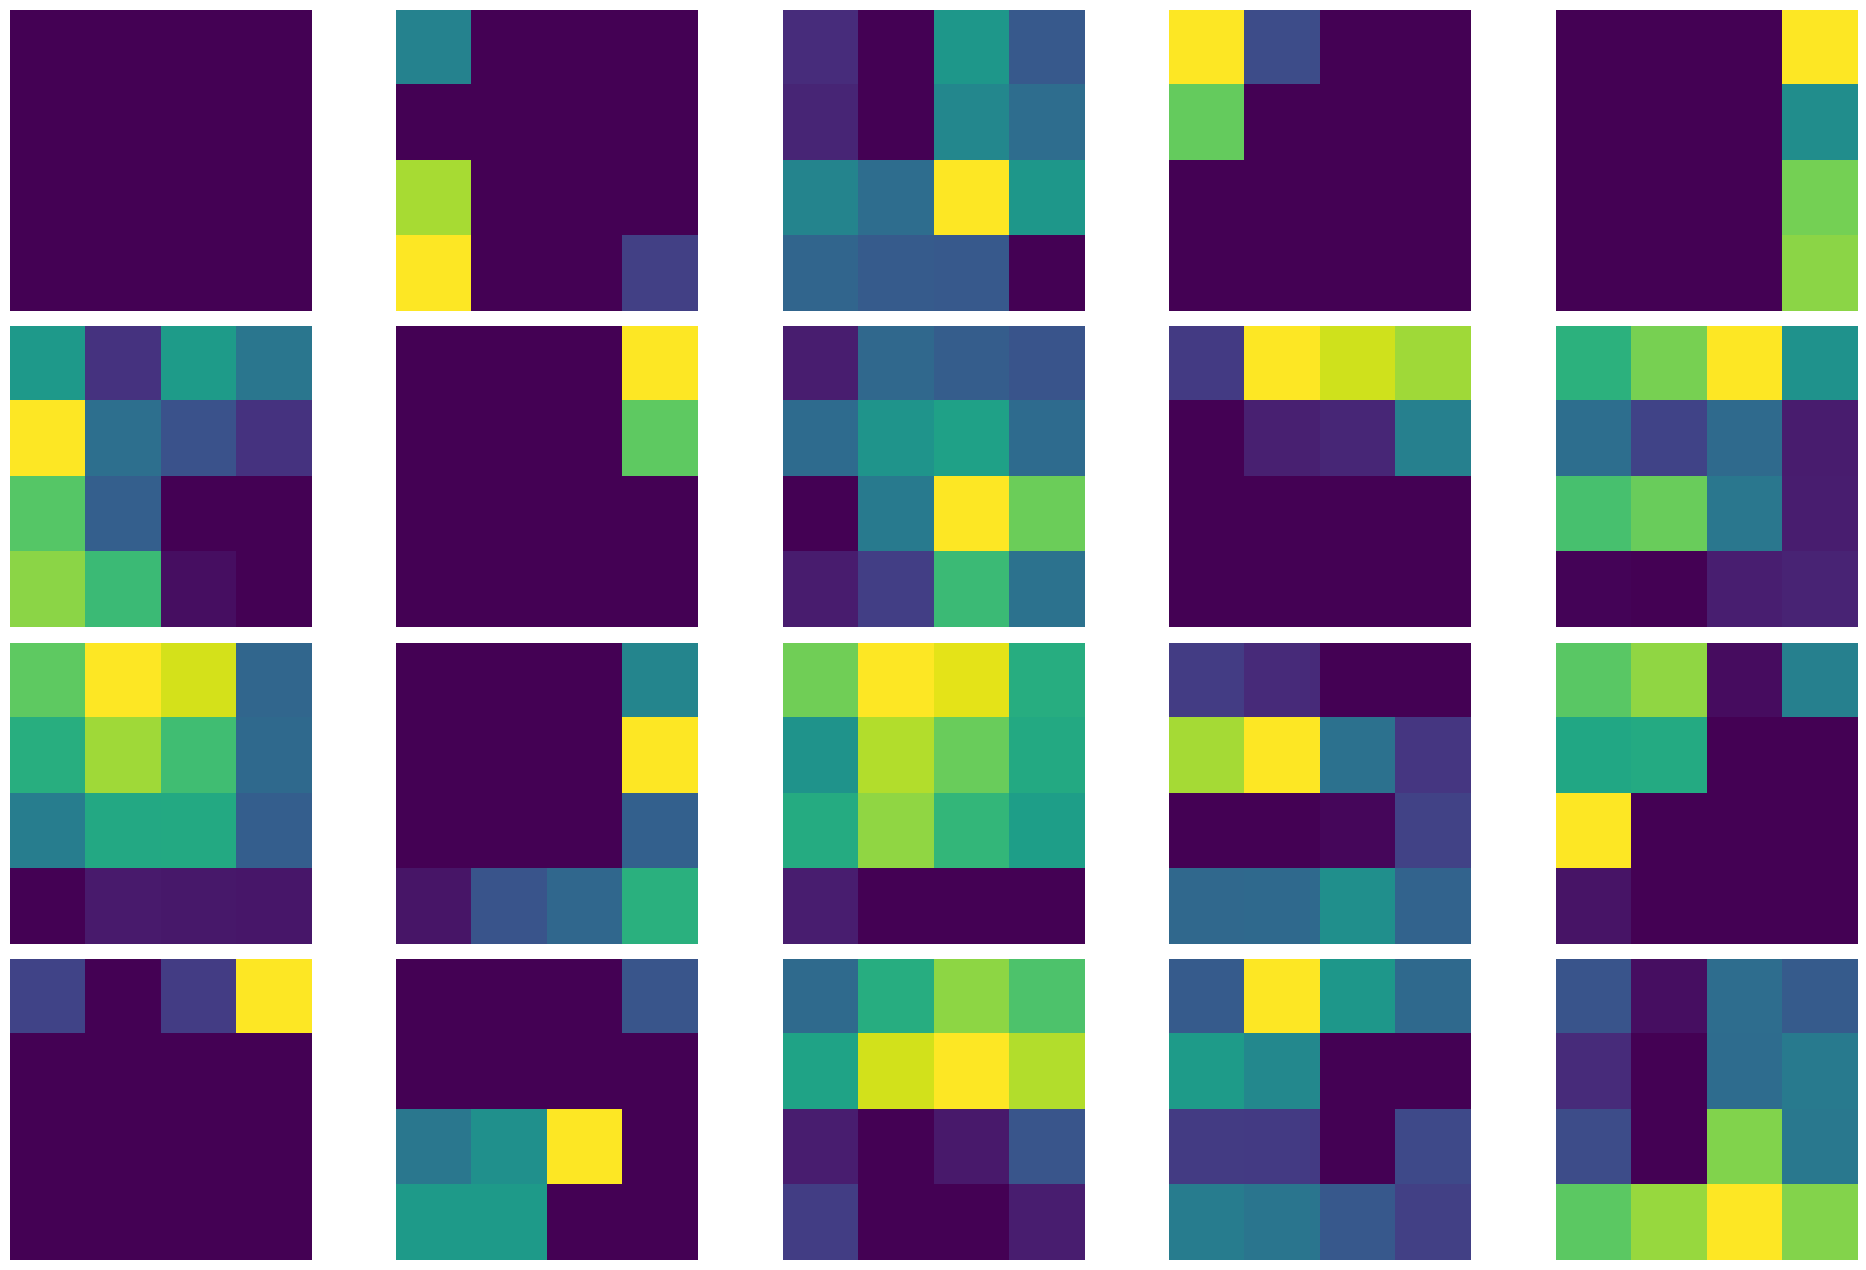

In [25]:
# Show first 10 feature map channels
show_k_feature_map_channels(feature_maps_conv1[0], k=64)
show_k_feature_map_channels(feature_maps_layer1[0], k=20)
show_k_feature_map_channels(feature_maps_layer2[0], k=20)
show_k_feature_map_channels(feature_maps_layer3[0], k=20)
show_k_feature_map_channels(feature_maps_layer4[0], k=20)

In [26]:
# Saliency Map
def compute_saliency_map(model, img, target_class):
    img.requires_grad = True
    output = model(img)
    model.zero_grad()
    output[0, target_class].backward()
    saliency_map = img.grad.data.abs().max(1)[0]
    return saliency_map

(128, 128)


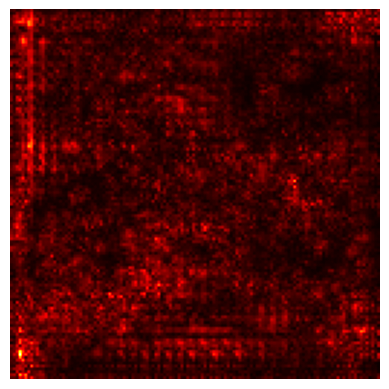

In [34]:
saliency = compute_saliency_map(model, img, 1)

saliency = saliency.squeeze().cpu().numpy()
print(saliency.shape)

# Plot
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.show()